In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras
import time
import imutils

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from typing import List
from pathlib import Path
from imutils.video import VideoStream
from PIL import Image

In [ ]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [26]:
!pip list | grep opencv

opencv-python                              4.1.2.30 


## Data Preprocessing

In [3]:
# get the data
filename = 'dataset/emotions_dataset.csv'
df = pd.read_csv(filename, na_filter=False)

In [4]:
df_train = df[(df.usage == 'Training') | (df.usage == 'PublicTest')].copy().reset_index()
df_train['labels'] = [label_map[e] for e in df_train.emotion]

df_test = df[df.usage == 'PrivateTest'].copy().reset_index()
df_test['labels'] = [label_map[e] for e in df_test.emotion]
del df


In [5]:
def pixels_to_images(pixels_series: pd.Series) -> np.ndarray:
    pixels_lists = [[int(n) for n in p.split()] for p in pixels_series]
    X = np.array(pixels_lists) / 255
    X = X.reshape(-1, 48, 48, 1)
    return X

In [6]:
npy_data = 'dataset/numpy_images.npy'
if Path(npy_data).is_file():
    with open('dataset/numpy_images.npy', 'rb') as f:
        X = np.load(f)
else:
    X = pixels_to_images(df_train.pixels)
    with open('dataset/numpy_images.npy', 'wb') as f:
        np.save(f, X)

X_test = pixels_to_images(df_test.pixels)

Y = df_train.emotion.astype(int).to_list()
y_test = df_test.emotion.astype(int).to_list()

print(X.shape)

(32298, 48, 48, 1)


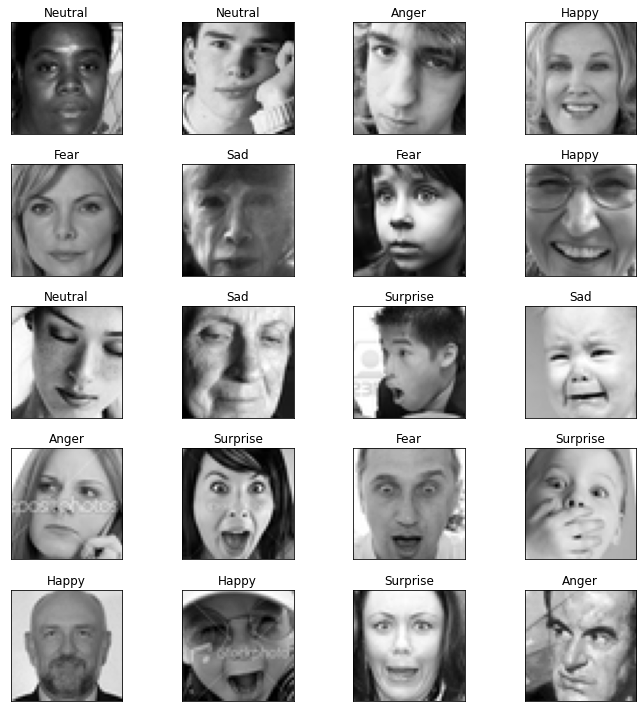

In [7]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
true_labels = []
preds = []
for i in range(1, columns*rows +1):
    img_id = np.random.choice(X.shape[0])
    img = X[img_id, :, :, 0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    true_labels.append(df_train.labels.iloc[img_id])
    preds.append(true_labels[i-1])
    plt.title(f"{true_labels[i-1]}")
fig.tight_layout()
plt.show()

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=0)

In [9]:
X_train.shape

(29068, 48, 48, 1)

## Define Model and Train on a Conv-Net

In [ ]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    optim = tf.keras.optimizers.Adam(learning_rate=2e-4)
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optim)
    
    return model
model=my_model()
# model.summary()

In [ ]:
image_generator = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.1,  # set range for random shear
    zoom_range=0.0,  # set range for random zoom
    channel_shift_range=0.0,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode="nearest",
    cval=0.0,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format="channels_last",
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0,
)
image_generator = image_generator.flow(X_train, y_train, batch_size=64)

val_generator = ImageDataGenerator()
val_generator = val_generator.flow(X_val, y_val, batch_size=64)

In [ ]:
path_model='checkpoints/{epoch:02d}-{val_loss:.6f}.hdf5'
Path('checkpoints').mkdir(parents=True, exist_ok=True)
h = model.fit(
    x=image_generator, 
    steps_per_epoch=len(X_train) // 64,
    epochs=100, 
    verbose=1, 
    validation_data=val_generator,
    shuffle=True,
    callbacks=[
        ModelCheckpoint(filepath=path_model),
        EarlyStopping(patience=15),
        ReduceLROnPlateau(patience=6, factor=0.3)
    ]
)

## Evaluate Model

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
true_labels = []
preds = []
preds = model.predict(X_test)
for i in range(1, columns*rows +1):
    img_id = np.random.choice(X_test.shape[0])
    img = X_test[img_id, :, :, 0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{label_map[y_test[img_id]]}, {label_map[np.argmax(preds[img_id])]}")
fig.tight_layout()
plt.show()

## Transfer Learning on MobileNet-V2

In [24]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(label_map), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
    
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

//miniconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [11]:
X_train.shape

(29068, 48, 48, 1)

In [12]:
arrays = []
for arr in X_train[:,:,:,0]:
    arrays.append(np.array(Image.fromarray(arr).resize(size=(224, 224))))
X_train_224 = np.array(arrays)

In [27]:
X_train_224.shape

(29068, 224, 224, 1)

In [28]:
arrays = []
for arr in X_val[:,:,:,0]:
    arrays.append(np.array(Image.fromarray(arr).resize(size=(224, 224))))
X_val_224 = np.array(arrays)
X_val_224.shape

(3230, 224, 224)

In [14]:
arrays = []
for arr in X_test[:,:,:,0]:
    arrays.append(np.array(Image.fromarray(arr).resize(size=(224, 224))))
X_test_224 = np.array(arrays)

In [16]:
X_test_224.shape

(3589, 224, 224)

In [ ]:
X_train_224 = np.expand_dims(X_train_224, axis=-1)
X_val_224 = np.expand_dims(X_val_224, axis=-1)
X_test_224 = np.expand_dims(X_test_224, axis=-1)


In [22]:
X_test_224.shape

(3589, 224, 224, 1)

In [25]:
X_train_224.shape

(29068, 224, 224, 1)

In [30]:
image_generator = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.1,  # set range for random shear
    zoom_range=0.0,  # set range for random zoom
    channel_shift_range=0.0,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode="nearest",
    cval=0.0,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format="channels_last",
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0,
)
image_generator = image_generator.flow(X_train_224, y_train, batch_size=64)

val_generator = ImageDataGenerator()
val_generator = val_generator.flow(X_val_224, y_val, batch_size=64)

In [ ]:
checkpoint_path = Path('checkpoints/mobilenet')
checkpoint_path.mkdir(parents=True, exist_ok=True)
path_model=f'{checkpoint_path}/{epoch:02d}-{val_loss:.6f}.hdf5'

h = model.fit(
    x=image_generator, 
    steps_per_epoch=len(X_train) // 64,
    epochs=100, 
    verbose=1, 
    validation_data=val_generator,
    shuffle=True,
    callbacks=[
        ModelCheckpoint(filepath=path_model),
        EarlyStopping(patience=15),
        ReduceLROnPlateau(patience=6, factor=0.3)
    ]
)

## Inference on Single Image

In [3]:
expressionNet = load_model('artifacts/34-0.953775.hdf5')

prototxtPath = "face_detector/deploy.prototxt"
weightsPath = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
image = cv2.imread('dataset/example_images/surprised.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

net.setInput(blob)
detections = faceNet.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        height = endY - startY
        
        midX = int((endX + startX) / 2)
        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, (midX - int(height / 2)):(midX + int(height / 2))]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, (48, 48))
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)

        # pass the face through the model to determine if the face
        # has a mask or not
        preds = expressionNet.predict(face)[0]

        # determine the class label and color we'll use to draw
        # the bounding box and text
        color = (0, 255, 0)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label_map[np.argmax(preds)], max(preds) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

cv2.imshow("Output", image)
while True:
    key = cv2.waitKey(0)
    if key in [27, ord('q'), ord('Q')]:
        cv2.destroyAllWindows()
        break

In [ ]:
plt.imshow(np.squeeze(face[0,:,:,:]), cmap='gray')

## Expression Detection in Video

In [4]:
def detect_and_predict_expression(frame, faceNet, expressionNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.8:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            height = endY - startY

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            midX = int((endX + startX) / 2)

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, (midX - int(height / 2)):(midX + int(height / 2))]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face = cv2.resize(face, (48, 48))
            face = img_to_array(face)
#             face = np.expand_dims(face, axis=0)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = expressionNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

In [5]:
vs = VideoStream(src=0).start()
time.sleep(2.0)

In [6]:
frame = vs.read()

while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    (locs, preds) = detect_and_predict_expression(frame, faceNet, expressionNet)

    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box

        # determine the class label and color we'll use to draw
        # the bounding box and text
        color = (0, 255, 0)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label_map[np.argmax(pred)], max(pred) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()
vs.stop()

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Found 28709 images belonging to 7 classes.
# Found 3589 images belonging to 7 classes.


# nb_train_samples = 28273
# nb_validation_samples = 3534
nb_train_samples = 28709
nb_validation_samples = 3589

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [ ]:
def emotion_analysis(emotions):
    y_pos = np.arange(len(label_map))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, label_map)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [ ]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

In [ ]:
#import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import confusion_matrix
#%matplotlib inline
#cm = confusion_matrix(np.where(y_test == 1)[1], y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#df_cm = pd.DataFrame(cm, index = [i for i in "0123456"],
                  #columns = [i for i in "0123456"])
#plt.figure(figsize = (20,15))
#sn.heatmap(df_cm, annot=True)

**Real Time Expression Prediction**

In [ ]:
from skimage import io
img = image.load_img('../input/myimage/Shawon.jpg', grayscale=True, target_size=(48, 48))
show_img = image.load_img('../input/myimage/Shawon.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

**Live Demo of Production Level Project**

[Facial Expression Detection Web App](https://faceai.herokuapp.com/)